In [1]:
!nvidia-smi

Thu May 20 08:16:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


In [3]:
!git clone https://github.com/eagle705/pytorch-bert-crf-ner

Cloning into 'pytorch-bert-crf-ner'...
remote: Enumerating objects: 1707, done.
remote: Counting objects: 100% (1707/1707), done.
remote: Compressing objects: 100% (1618/1618), done.
remote: Total 1707 (delta 109), reused 1663 (delta 71), pack-reused 0
Receiving objects: 100% (1707/1707), 27.16 MiB | 3.50 MiB/s, done.
Resolving deltas: 100% (109/109), done.


In [6]:
!pip uninstall torch torchvision torchtext -y
!pip install torch==1.7.1 torchvision==0.8.2 torchtext==0.8.1
!pip install transformers

Uninstalling torch-1.7.1:
  Successfully uninstalled torch-1.7.1
Uninstalling torchvision-0.8.2:
  Successfully uninstalled torchvision-0.8.2
Uninstalling torchtext-0.8.1:
  Successfully uninstalled torchtext-0.8.1
  Using cached https://files.pythonhosted.org/packages/90/5d/095ddddc91c8a769a68c791c019c5793f9c4456a688ddd235d6670924ecb/torch-1.7.1-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/94/df/969e69a94cff1c8911acb0688117f95e1915becc1e01c73e7960a2c76ec8/torchvision-0.8.2-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/13/80/046f0691b296e755ae884df3ca98033cb9afcaf287603b2b7999e94640b8/torchtext-0.8.1-cp37-cp37m-manylinux1_x86_64.whl
/bin/bash: =4: No such file or directory


In [53]:
import os, re

In [80]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import (
    BertConfig, BertForTokenClassification, BertTokenizer, # for KcBERT
)

In [77]:
class KMAOUNERPreprocessor(object):
    """한국해양대 NER 데이터셋 전처리"""

    @staticmethod
    def load_dataset_from_files(dataset_path: str) -> (list, list):
        txt_filenames = os.listdir(dataset_path)
        txt_filenames = list(filter(lambda filename: filename.endswith(".txt"), txt_filenames))
        txt_filepaths = list(map(lambda filename: os.path.join(dataset_path, filename), txt_filenames))

        total_source_text_list = []
        total_target_text_list = []
        for txt_filepath in txt_filepaths:
            source_text_list, target_text_list = KMAOUNERPreprocessor.load_text_and_label_from_txt(txt_filepath)
            total_source_text_list += source_text_list
            total_target_text_list += target_text_list

        return total_source_text_list, total_target_text_list

    @staticmethod
    def load_text_and_label_from_txt(txt_filepath: str) -> (list, list):
        source_text_list = []
        target_text_list = []

        f = open(txt_filepath, 'r')
        txt = f.read()
        sentenses = txt.split("\n\n")
        for sentense in sentenses:
            lines = sentense.split("\n")
            if len(lines) < 3:
                continue
            source_text = lines[1].replace("## ", "")
            target_text = lines[2].replace("## ", "")

            source_text_list.append(source_text)
            target_text_list.append(target_text)

        return source_text_list, target_text_list

    @staticmethod
    def create_labels(total_target_text_list: [str]):
        labels = ['O']
        toal_tags = []
        for total_target_text in total_target_text_list:
            tags = re.findall(r'\<(.*?)\>', total_target_text)  # find all content between < and >
            tags = list(filter(lambda tag: len(tag.split(":")) == 2, tags))
            tags = list(map(lambda tag: tag.split(":")[-1], tags))  # only tag names
            tags = list(dict.fromkeys(tags))  # remove duplications
            for tag in tags:
                if tag not in toal_tags:
                    toal_tags.append(tag)
        for tag in toal_tags:
            labels.append(f'B-{tag}')
            labels.append(f'I-{tag}')

        return labels

    @staticmethod
    def preprocess(tokenizer, source_text_list, target_text_list, label_map, max_seq_len, pad_token_label_id=-100):  # bert의 최대 maxlen을 사용하는것을 
        list_of_token_ids = []
        list_of_attension_mask = []
        list_of_label_ids = []

        for source_text, target_text in zip(source_text_list, target_text_list):
            # source_text:
            # 이미 수상자(2000년 김대중 전 대통령)를 배출한 데다
            # target_text:
            # 이미 수상자(<2000년:DAT> <김대중:PER> 전 대통령)를 배출한 데다
            tokens = tokenizer.tokenize(source_text)  # ['이미', '수상', '##자', '(', '2000', '##년', '김대중', '전', '대통령', ')', '를', '배출', '##한', '데', '##다']
            
            labels = []
            target_text = target_text.replace(" ", "")
            current_tag = None
            tagged_text = None
            for token in tokens:
                token = token.replace("##", "")
                # print("token:", token)

                if target_text.index(token) == 0:
                    if current_tag is None:
                        labels.append('O')
                        target_text = target_text[len(token):]
                    else:
                        labels.append(f'I-{current_tag}')
                        target_text = target_text[len(token):]
                        tagged_text = tagged_text[len(token):]
                        if len(tagged_text) == 0:
                            current_tag = None
                            tagged_text = None
                else:
                    if target_text[0] == '<':
                        target_text = target_text[1:]
                        current_tag = target_text[target_text.index(":")+1:target_text.index(">")]
                        tagged_text = target_text[:target_text.index(":")]
                        target_text = target_text[:target_text.index(":")] + target_text[target_text.index(">", target_text.index(":"))+1:]
                        target_text = target_text[len(token):]
                        tagged_text = tagged_text[len(token):]
                        # print("  tag:", current_tag)
                        labels.append(f'B-{current_tag}')

                token_ids = [tokenizer.cls_token] + token_ids + [tokenizer.sep_token]
                token_ids = tokenizer.convert_tokens_to_ids(tokens)
                padding_length = max_seq_len - len(token_ids)

                attension_mask = [1]*len(token_ids) + [0]*padding_length
                token_ids = token_ids + [tokenizer.pad_token_id]*padding_length

                label_ids = [pad_token_label_id] + list(map(lambda x: label_map[x], labels)) + [pad_token_label_id] + [ ]*padding_length


                list_of_token_ids.append(token_ids)
                list_of_attension_mask.append(attension_mask)
                list_of_label_ids.append(label_ids)

        
        return list_of_token_ids, \
            list_of_attension_mask, \
            list_of_label_ids
    

In [78]:
class KMAOUNERDataset(torch.utils.data.Dataset):

    def __init__(self, dataset_path, max_seq_len):
        assert os.path.exists(dataset_path)
        self.dataset_path = dataset_path
        self.max_seq_len = max_seq_len

        source_text_list, target_text_list = KMAOUNERPreprocessor.load_dataset_from_files(dataset_path=dataset_path)
        assert len(source_text_list) == len(target_text_list), "Err: Number of source and target is different"

        labels = KMAOUNERPreprocessor.create_labels(total_target_text_list=target_text_list)
        label_map = {label: i for i, label in enumerate(labels)}

        list_of_token_ids, \
        list_of_attension_mask, \
        list_of_label_ids = KMAOUNERPreprocessor.preprocess(tokenizer, source_text_list, target_text_list, label_map, max_seq_len)

        self.list_of_token_ids      = list_of_token_ids
        self.list_of_attension_mask = list_of_attension_mask
        self.list_of_label_ids      = list_of_label_ids
        self.labels                 = labels

    def __len__(self):
        return len(self.list_of_token_ids)

    def __getitem__(self, data_idx: int):
        return self.list_of_token_ids[data_idx], \
            self.list_of_attension_mask[data_idx], \
            self.list_of_label_ids[data_idx]

In [79]:
"""config 파일 안에 들어갈 내용"""
dataset_train_path  = "pytorch-bert-crf-ner/data_in/NER-master/말뭉치 - 형태소_개체명"
model_name          = "beomi/kcbert-base"
ModelConfig         = BertConfig
Tokenizer           = BertTokenizer
Model               = BertForTokenClassification
max_seq_len         = 50

In [62]:
# !ls "pytorch-bert-crf-ner/data_in/NER-master/말뭉치 - 형태소_개체명"
dataset_train = KMAOUNERDataset(dataset_train_path, max_seq_len=max_seq_len)

In [63]:
labels    = dataset_train.labels
id2label  = {str(i): label for i, label in enumerate(labels)}
label2id  = {label: i for i, label in enumerate(labels)}
print("len(labels):", len(labels))
print("labels:", labels)
print("id2label:", id2label)
print("label2id:", label2id)
print()

config    = ModelConfig.from_pretrained(model_name, num_labels=len(labels), id2label=id2label, label2id=label2id)
tokenizer = Tokenizer.from_pretrained(model_name, do_lower_case=False)
model     = Model.from_pretrained(model_name, config=config)

len(labels): 21
labels: ['O', 'B-POH', 'I-POH', 'B-NOH', 'I-NOH', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-DAT', 'I-DAT', 'B-MNY', 'I-MNY', 'B-LOC', 'I-LOC', 'B-PNT', 'I-PNT', 'B-DUR', 'I-DUR', 'B-TIM', 'I-TIM']
id2label: {'0': 'O', '1': 'B-POH', '2': 'I-POH', '3': 'B-NOH', '4': 'I-NOH', '5': 'B-PER', '6': 'I-PER', '7': 'B-ORG', '8': 'I-ORG', '9': 'B-DAT', '10': 'I-DAT', '11': 'B-MNY', '12': 'I-MNY', '13': 'B-LOC', '14': 'I-LOC', '15': 'B-PNT', '16': 'I-PNT', '17': 'B-DUR', '18': 'I-DUR', '19': 'B-TIM', '20': 'I-TIM'}
label2id: {'O': 0, 'B-POH': 1, 'I-POH': 2, 'B-NOH': 3, 'I-NOH': 4, 'B-PER': 5, 'I-PER': 6, 'B-ORG': 7, 'I-ORG': 8, 'B-DAT': 9, 'I-DAT': 10, 'B-MNY': 11, 'I-MNY': 12, 'B-LOC': 13, 'I-LOC': 14, 'B-PNT': 15, 'I-PNT': 16, 'B-DUR': 17, 'I-DUR': 18, 'B-TIM': 19, 'I-TIM': 20}



Some weights of the model checkpoint at beomi/kcbert-base were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the

In [67]:
print(tokenizer.tokenize("안녕하세요 저는 곽도영입니다.👍"))  # ['안녕', '##하세요', '저는', '곽', '##도', '##영', '##입니다', '.', '👍']
print(tokenizer.tokenize("이미 수상자(2000년 김대중 전 대통령)를 배출한 데다"))  # ['이미', '수상', '##자', '(', '2000', '##년', '김대중', '전', '대통령', ')', '를', '배출', '##한', '데', '##다']

['이미',
 '수상',
 '##자',
 '(',
 '2000',
 '##년',
 '김대중',
 '전',
 '대통령',
 ')',
 '를',
 '배출',
 '##한',
 '데',
 '##다']

In [76]:
# for test!
source_text = "이미 수상자(2000년 김대중 전 대통령)를 배출한 데다"
target_text = "이미 수상자(<2000년:DAT> <김대중:PER> 전 대통령)를 배출한 데다"
tokens = tokenizer.tokenize(source_text)  # ['이미', '수상', '##자', '(', '2000', '##년', '김대중', '전', '대통령', ')', '를', '배출', '##한', '데', '##다']

labels = []
target_text = target_text.replace(" ", "")
current_tag = None
tagged_text = None
for token in tokens:
    token = token.replace("##", "")
    # print("token:", token)

    if target_text.index(token) == 0:
        if current_tag is None:
            labels.append('O')
            target_text = target_text[len(token):]
        else:
            labels.append(f'I-{current_tag}')
            target_text = target_text[len(token):]
            tagged_text = tagged_text[len(token):]
            if len(tagged_text) == 0:
                current_tag = None
                tagged_text = None
    else:
        if target_text[0] == '<':
            target_text = target_text[1:]
            current_tag = target_text[target_text.index(":")+1:target_text.index(">")]
            tagged_text = target_text[:target_text.index(":")]
            target_text = target_text[:target_text.index(":")] + target_text[target_text.index(">", target_text.index(":"))+1:]
            target_text = target_text[len(token):]
            tagged_text = tagged_text[len(token):]
            # print("  tag:", current_tag)
            labels.append(f'B-{current_tag}')

for token, label in zip(tokens, labels):
    print(token, label)

이미 O
수상 O
##자 O
( O
2000 B-DAT
##년 I-DAT
김대중 B-PER
전 I-PER
대통령 O
) O
를 O
배출 O
##한 O
데 O
##다 O


In [64]:
# GPU or CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

In [82]:
# train_sampler = RandomSampler(dataset_train)  # 
# shuffle=True, drop_last=True -> 1,2,3,4,5,6, minibatch:4,     4,3,5,1,6,2 => 4,3,5,1(6,2)
# collate_fn -> mini batch tensor를 만듦, list of tensor로 만
# maxlen 
dataloader_train = DataLoader(dataset_train, batch_size=64, shuffle=True, drop_last=True) # , collate_fn=??)
dataloader_valid = DataLoader(dataset_valid, batch_size=64, shuffle=False, drop_last=False)

NameError: ignored

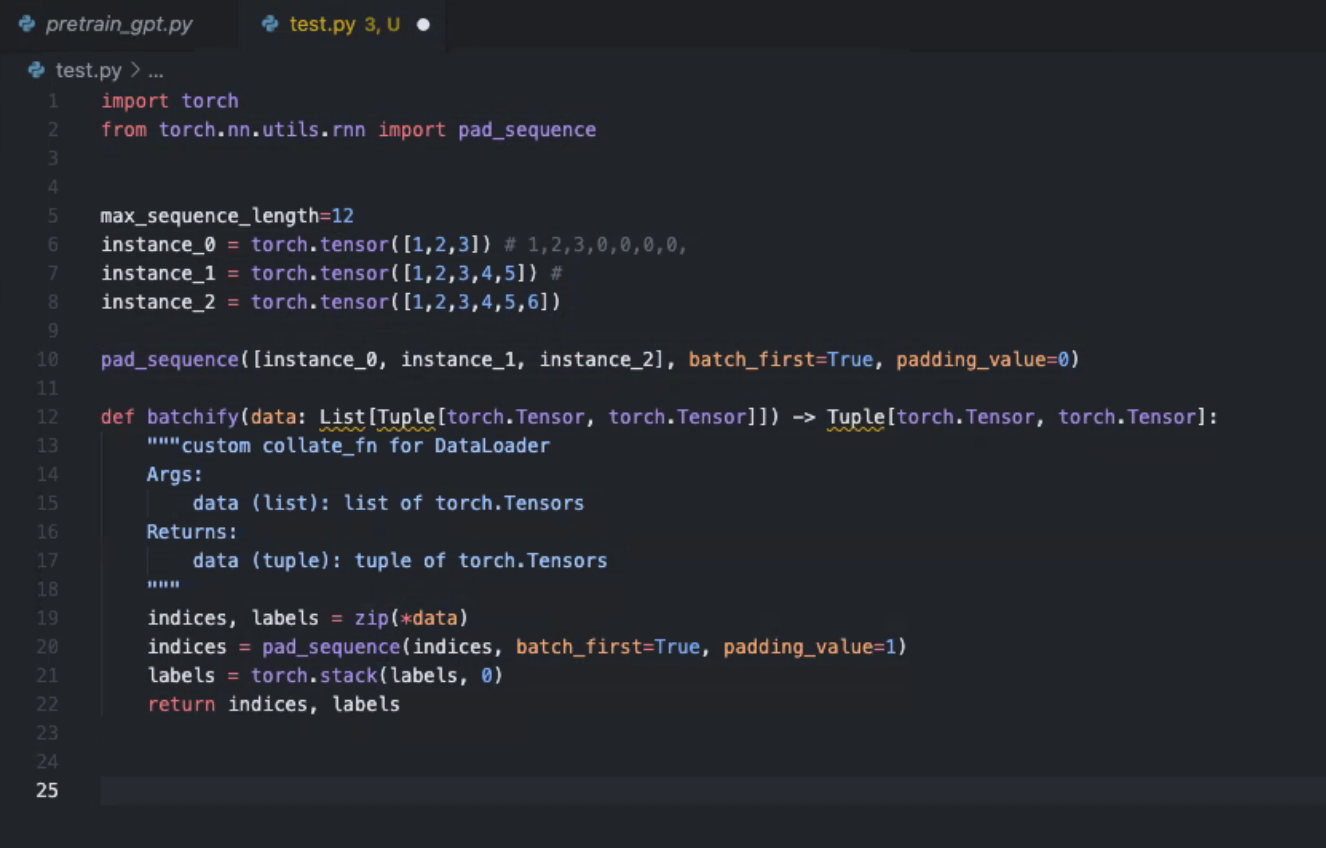

## 모델 돌려보기

BERT finetuning 꿀팁 물어보기
-> leanring rate 관련